In [6]:
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2  import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input,
    GlobalAveragePooling2D,
    Dense,
    BatchNormalization,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings('ignore')






In [8]:
# -----------------------------------
# 1. Ustawienia i ścieżki
# -----------------------------------
image_shape = (224, 224)
batch_size  = 32
epochs_stage1 = 10
epochs_stage2 = 5

data_path    = r'C:/Users/Ania/Desktop/dataset2/archive (1)/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_folder = os.path.join(data_path, 'train')
valid_folder = os.path.join(data_path, 'valid')
test_folder  = os.path.join(data_path, 'test')


In [10]:
# -----------------------------------
# 2. Generatory danych z augmentacją i preprocess_input
# -----------------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    valid_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Train: {train_data.samples} obrazów w {train_data.num_classes} klasach")
print(f"Valid: {valid_data.samples} obrazów w {valid_data.num_classes} klasach")
print(f"Test:  {test_data.samples} obrazów w {test_data.num_classes} klasach")

num_classes = train_data.num_classes


Found 140590 images belonging to 38 classes.
Found 34384 images belonging to 38 classes.
Found 760 images belonging to 38 classes.
Train: 140590 obrazów w 38 klasach
Valid: 34384 obrazów w 38 klasach
Test:  760 obrazów w 38 klasach


In [7]:

# -----------------------------------
# 3. Budowa modelu MobileNetV2 + głębszy head z L2 i Dropout
# -----------------------------------
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_shape[0], image_shape[1], 3)
)
base_model.trainable = False

inputs = Input(shape=(image_shape[0], image_shape[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_mobilenetv2 = Model(inputs=inputs, outputs=outputs)

model_mobilenetv2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mobilenetv2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,086,054 (11.77 MB)

 Trainable params: 826,534 (3.15 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [9]:

# -----------------------------------
# 4. Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# -----------------------------------
checkpoint_1 = ModelCheckpoint(
    'mobilenetv2_best_v2.keras',    # <- zmienione rozszerzenie
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
early_stop_1 = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)
reduce_lr_1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)



Epoch 1/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5059s 1s/step - accuracy: 0.5019 - loss: 1.9596 - val_accuracy: 0.9070 - val_loss: 0.3981 - learning_rate: 1.0000e-04
Epoch 2/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5036s 1s/step - accuracy: 0.8559 - loss: 0.5600 - val_accuracy: 0.9317 - val_loss: 0.3058 - learning_rate: 1.0000e-04
Epoch 3/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 4940s 1s/step - accuracy: 0.8879 - loss: 0.4480 - val_accuracy: 0.9430 - val_loss: 0.2711 - learning_rate: 1.0000e-04
Epoch 4/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 4932s 1s/step - accuracy: 0.9063 - loss: 0.3848 - val_accuracy: 0.9452 - val_loss: 0.2544 - learning_rate: 1.0000e-04
Epoch 5/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 4998s 1s/step - accuracy: 0.9168 - loss: 0.3504 - val_accuracy: 0.9440 - val_loss: 0.2512 - learning_rate: 1.0000e-04
Epoch 6/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 5131s 1s/step - accuracy: 0.9218 - loss: 0.3319 - val_accuracy: 0.9502 - val_loss: 0.2368 - learning_rate: 1.0000e-04
Epoch 7/10
4394/4394 ━━━━━━━━━━━━━━━━━━━

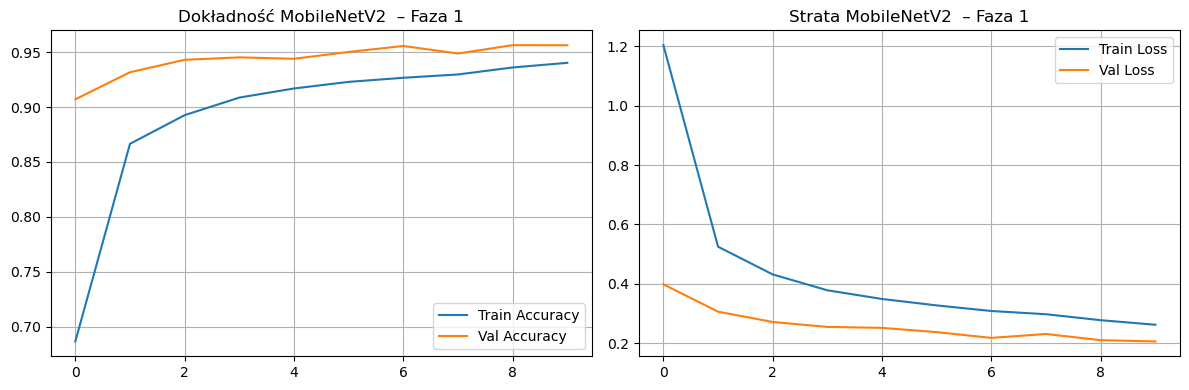

In [11]:
# -----------------------------------
# 5. Etap 1: Trening tylko “head” (base_model zamrożony)
# -----------------------------------
history_stage1 = model_mobilenetv2.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs_stage1,
    callbacks=[checkpoint_1, early_stop_1, reduce_lr_1]
)

# Wyświetlenie krzywych uczenia po fazie 1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Val Accuracy')
plt.title('Dokładność MobileNetV2  – Faza 1')
plt.legend(), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'], label='Val Loss')
plt.title('Strata MobileNetV2  – Faza 1')
plt.legend(), plt.grid()

plt.tight_layout()
plt.show()



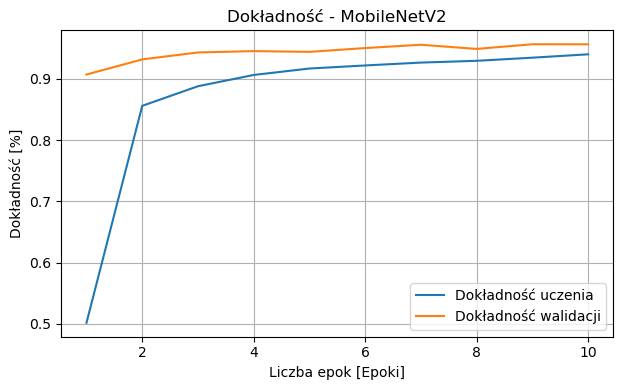

In [7]:
import matplotlib.pyplot as plt

# Dane z outputu
accuracy = [0.5019, 0.8559, 0.8879, 0.9063, 0.9168, 0.9218, 0.9265, 0.9294, 0.9345, 0.9400]
val_accuracy = [0.9070, 0.9317, 0.9430, 0.9452, 0.9440, 0.9502, 0.9556, 0.9488, 0.9564, 0.9563]
loss = [1.9596, 0.5600, 0.4480, 0.3848, 0.3504, 0.3319, 0.3097, 0.2996, 0.2823, 0.2619]
val_loss = [0.3981, 0.3058, 0.2711, 0.2544, 0.2512, 0.2368, 0.2174, 0.2306, 0.2097, 0.2054]

epochs = list(range(1, 11))

plt.figure(figsize=(12, 4))

# Wykres dokładności
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Dokładność uczenia',)
plt.plot(epochs, val_accuracy, label='Dokładność walidacji')
plt.title('Dokładność - MobileNetV2')
plt.xlabel('Liczba epok [Epoki]')
plt.ylabel('Dokładność [%]')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


In [13]:
# -----------------------------------
# 6. Ładowanie najlepszego checkpointu z Etapu 1
# -----------------------------------
model_mobilenetv2 = load_model('mobilenetv2_best_v2.keras')



In [15]:
# -----------------------------------
# 9. Ocena na zbiorze testowym
# -----------------------------------
test_loss, test_acc = model_mobilenetv2.evaluate(test_data, verbose=1)
print(f"\MobileNetV2 (po fine-tuning) – Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 663ms/step - accuracy: 0.9734 - loss: 0.1855
\MobileNetV2 (po fine-tuning) – Test Accuracy: 0.9579, Test Loss: 0.2138


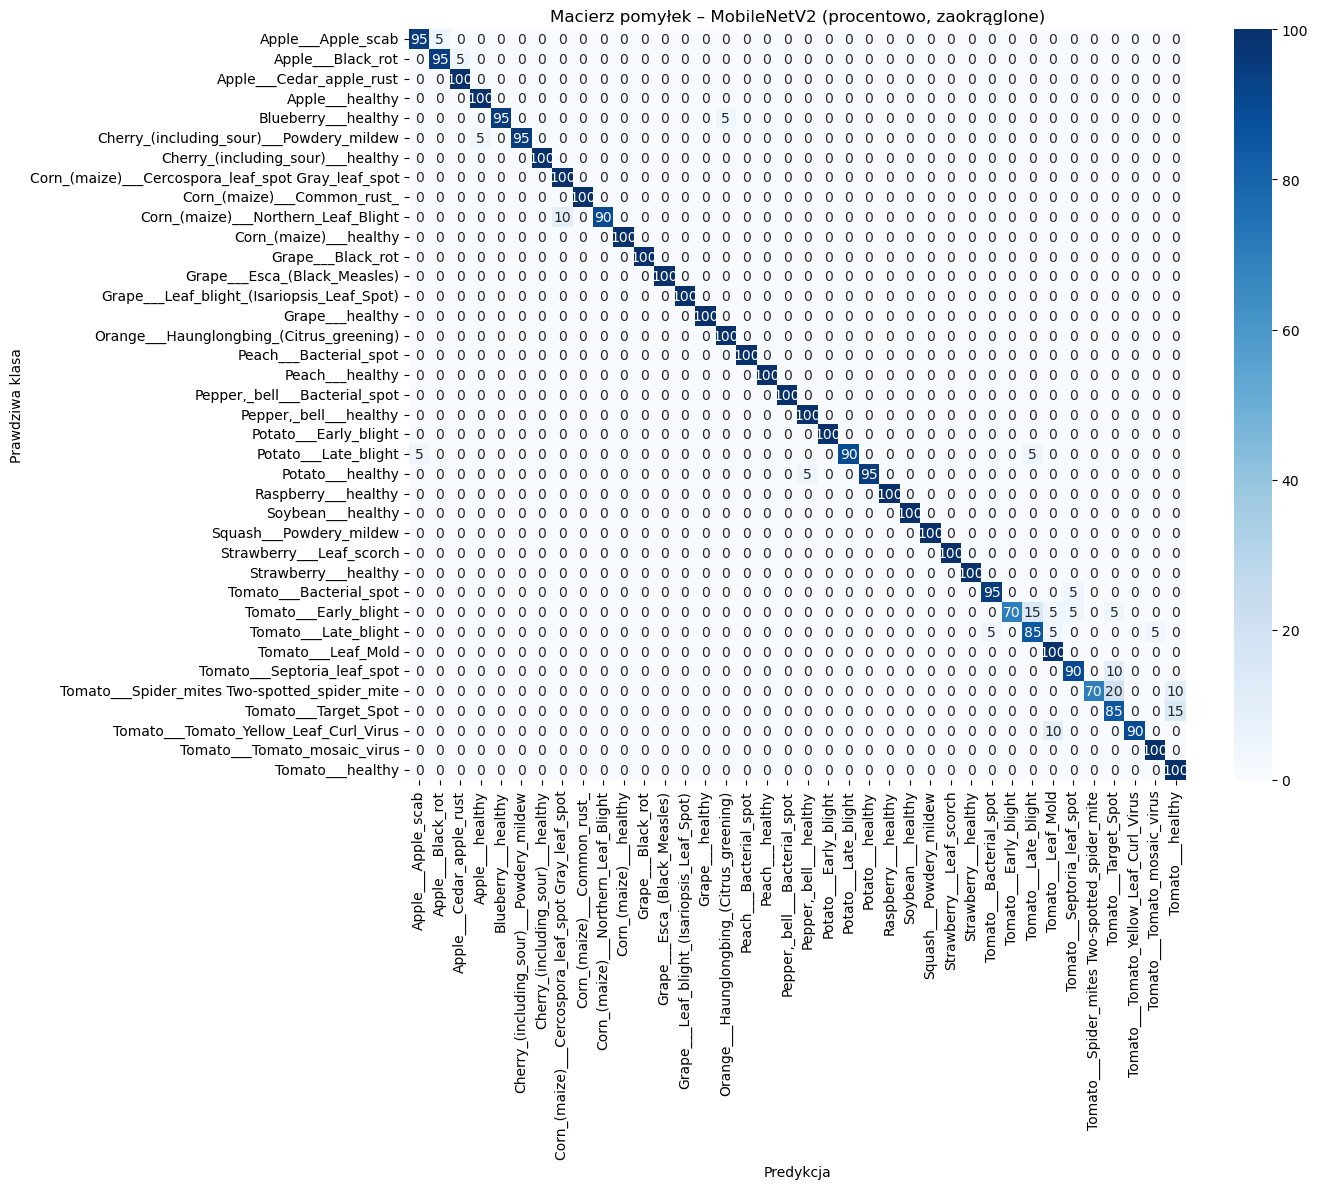


===== Raport klasyfikacji (Precision, Recall, F1) =====

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.95      0.95        20
                                 Apple___Black_rot       0.95      0.95      0.95        20
                          Apple___Cedar_apple_rust       0.95      1.00      0.98        20
                                   Apple___healthy       0.95      1.00      0.98        20
                               Blueberry___healthy       1.00      0.95      0.97        20
          Cherry_(including_sour)___Powdery_mildew       1.00      0.95      0.97        20
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        20
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      1.00      0.95        20
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        20
               Corn_(

In [16]:

# -----------------------------------
# 10. Macierz pomyłek i raport klasyfikacji
# -----------------------------------
# Klasy pobieramy z test_data.class_indices
class_names = list(test_data.class_indices.keys())

y_true = []
y_pred = []

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    preds = model_mobilenetv2.predict(x_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

    # Zatrzymujemy się, gdy przekroczymy liczbę próbek
    if (i + 1) * test_data.batch_size >= test_data.samples:
        break

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # w %

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Macierz pomyłek – MobileNetV2 (procentowo, zaokrąglone)")
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n===== Raport klasyfikacji (Precision, Recall, F1) =====\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


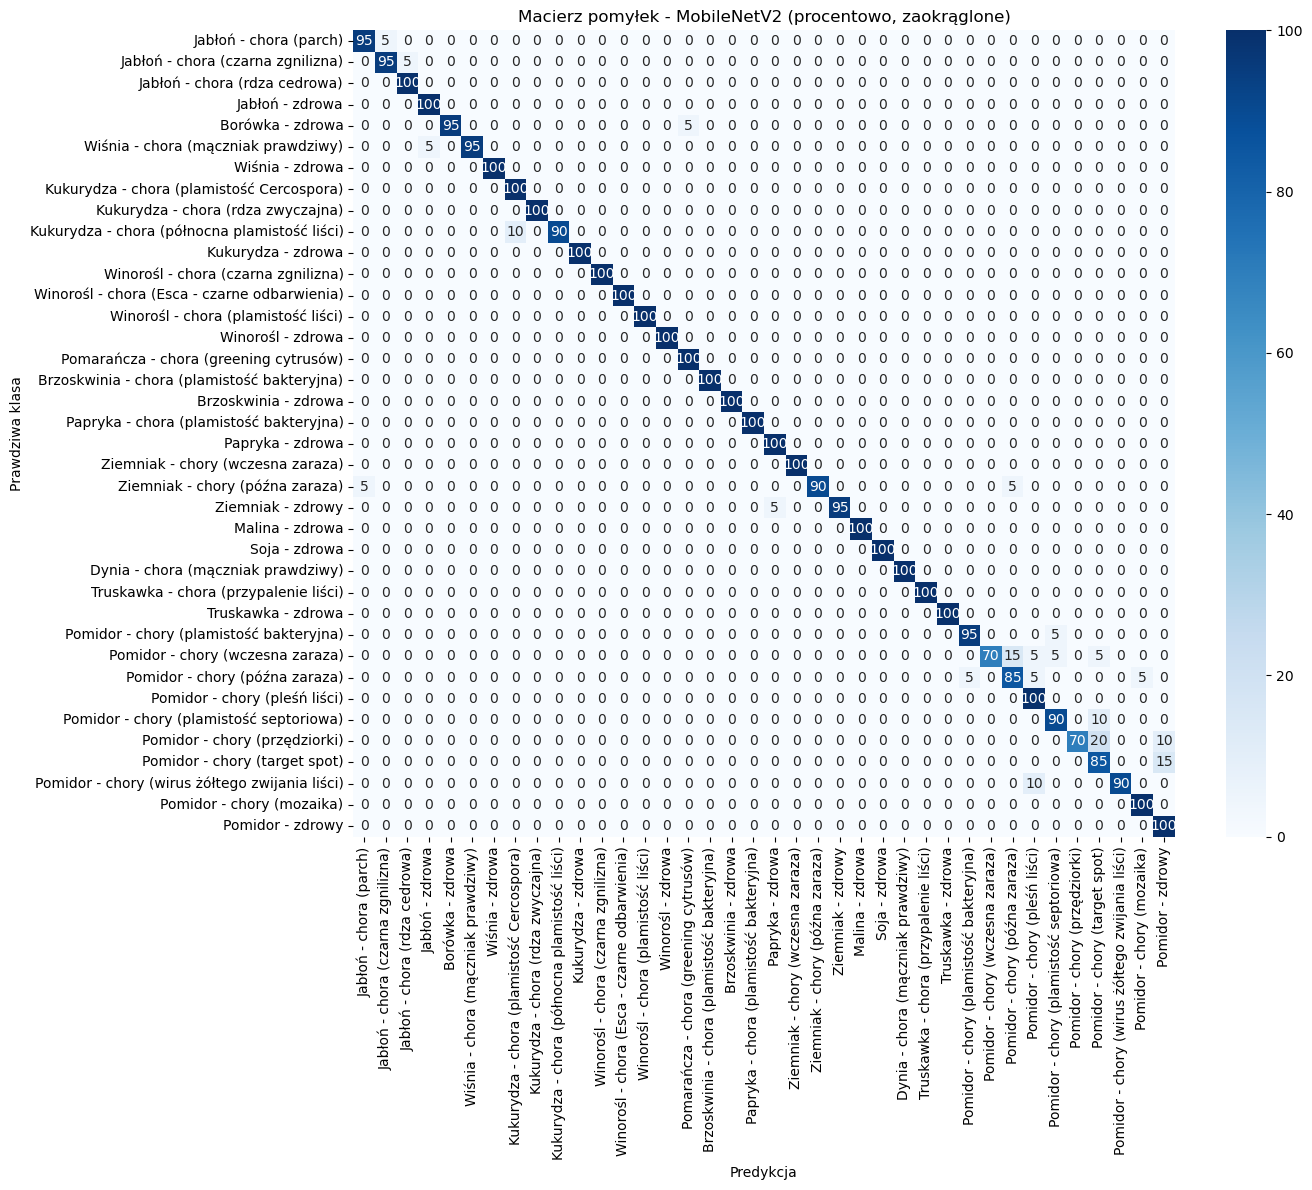

In [19]:
class_names_pl = [
    'Jabłoń - chora (parch)', 'Jabłoń - chora (czarna zgnilizna)', 'Jabłoń - chora (rdza cedrowa)', 'Jabłoń - zdrowa',
    'Borówka - zdrowa', 'Wiśnia - chora (mączniak prawdziwy)', 'Wiśnia - zdrowa',
    'Kukurydza - chora (plamistość Cercospora)', 'Kukurydza - chora (rdza zwyczajna)',
    'Kukurydza - chora (północna plamistość liści)', 'Kukurydza - zdrowa',
    'Winorośl - chora (czarna zgnilizna)', 'Winorośl - chora (Esca - czarne odbarwienia)',
    'Winorośl - chora (plamistość liści)', 'Winorośl - zdrowa',
    'Pomarańcza - chora (greening cytrusów)', 'Brzoskwinia - chora (plamistość bakteryjna)',
    'Brzoskwinia - zdrowa', 'Papryka - chora (plamistość bakteryjna)', 'Papryka - zdrowa',
    'Ziemniak - chory (wczesna zaraza)', 'Ziemniak - chory (późna zaraza)', 'Ziemniak - zdrowy',
    'Malina - zdrowa', 'Soja - zdrowa', 'Dynia - chora (mączniak prawdziwy)',
    'Truskawka - chora (przypalenie liści)', 'Truskawka - zdrowa',
    'Pomidor - chory (plamistość bakteryjna)', 'Pomidor - chory (wczesna zaraza)', 'Pomidor - chory (późna zaraza)',
    'Pomidor - chory (pleśń liści)', 'Pomidor - chory (plamistość septoriowa)',
    'Pomidor - chory (przędziorki)', 'Pomidor - chory (target spot)',
    'Pomidor - chory (wirus żółtego zwijania liści)', 'Pomidor - chory (mozaika)', 'Pomidor - zdrowy'
]

#macierz pomyłek
cm = confusion_matrix(y_true, y_pred)

#normalizowana w % (zaokrąglona)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

#pokaż macierz
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=class_names_pl, yticklabels=class_names_pl)
plt.title("Macierz pomyłek - MobileNetV2 (procentowo, zaokrąglone)")
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
from tensorflow.keras.models import load_model

model = load_model("mobilenetv2_best_v2.keras")
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Przewidywane etykiety jako argmax
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Prawdziwe etykiety
y_true = test_data.classes

# Nazwy klas
class_labels = list(test_data.class_indices.keys())

# Raport klasyfikacji
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

# Dokładność ogólna
print("Dokładność ogólna:", accuracy_score(y_true, y_pred))


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     0.9500    0.9500    0.9500        20
                                 Apple___Black_rot     0.9500    0.9500    0.9500        20
                          Apple___Cedar_apple_rust     0.9524    1.0000    0.9756        20
                                   Apple___healthy     0.9524    1.0000    0.9756        20
                               Blueberry___healthy     1.0000    0.9500    0.9744        20
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.9500    0.9744        20
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000        20
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9091    1.0000    0.9524        20
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        20
               Corn_(maize)___Norther